# Week 3 Inroduction
### Date: 21 Oct 2021

Last week you learned about different methods for segmenting an image into regions of interest. In this session you will get some experience coding image segmentation algorithms. Your task will be to code a simple statistical method that uses k-means clustering.

In [1]:
import numpy as np
import copy
import cv2
import matplotlib.image as mpimg
from matplotlib import pyplot as plt
%matplotlib inline
#to visualize the plots within the notebook

# K-means Segmentation
K-means clustering is a well-known approach for separating data (often of high dimensionality) into
different groups depending on their distance. In the case of images this is a useful method for
segmenting an image into regions, provided that the number of regions (k) is known in advance. It is
based on the fact that pixels belonging to the same region will most likely have similar intensities. 

The algorithm is:

a) Given the number of clusters, k, initialise their centres to some values.

b) Go over the pixels in the image and assign each one to its closest cluster according to its distance to the centre of the cluster.

c) Update the cluster centres to be the average of the pixels added.

d) Repeat steps b and c until the cluster centres do not get updated anymore.

## 1. Use the k-means function in sklearn and see results

First, you can use the built-in kmeans function in sklearn and see the results. 
You can figure out how to this from the specification: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

### Load image

Important Note: Don't forget to convert the image to float representation.

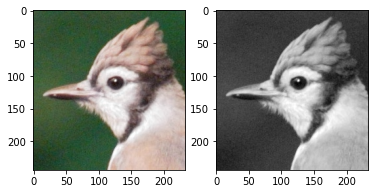

In [2]:
# Load image and conver to float representation
raw_img = cv2.imread("../images/sample_image.jpg")
# raw_img = np.flip(raw_img, 2) # do this if colour looks weird
raw_gray_img = cv2.cvtColor(raw_img, cv2.COLOR_BGR2GRAY)
img = raw_img.astype(np.float32) / 255.
gray_img = raw_gray_img.astype(np.float32) / 255.
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.imshow(gray_img, "gray")

### Results on Gray-scale Image

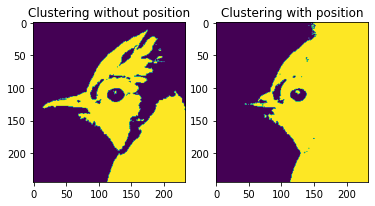

In [3]:
from sklearn.cluster import KMeans

_, plts = plt.subplots(1, 2)
plts = plts.flatten()
plts[0].set_title("Clustering without position")
km = KMeans(n_clusters=2, random_state=0)
feature_vectors = gray_img.reshape(-1, 1)
km.fit(feature_vectors)
label_img = km.labels_.reshape(gray_img.shape)
plts[0].imshow(label_img)

plts[1].set_title("Clustering with position")
km = KMeans(n_clusters=2, random_state=0)
feature_vectors = np.array([np.array([(a / gray_img.shape[0], b / gray_img.shape[1], gray_img[a][b]) for b in range(
    gray_img.shape[1])]) for a in range(gray_img.shape[0])])
km.fit(feature_vectors.reshape(-1, feature_vectors.shape[-1]))
label_img = km.labels_.reshape(gray_img.shape)
plts[1].imshow(label_img)



### Results on RGB image

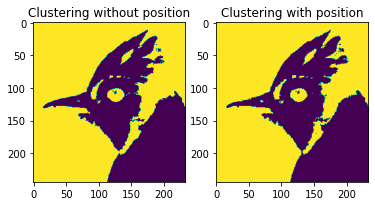

In [4]:
from sklearn.cluster import KMeans

_, plts = plt.subplots(1, 2)
plts = plts.flatten()
plts[0].set_title("Clustering without position")
km = KMeans(n_clusters=2, random_state=0)
feature_vectors = img.reshape(-1, 3)
km.fit(feature_vectors)
label_img = km.labels_.reshape((img.shape[0], img.shape[1], 1))
plts[0].imshow(label_img)

plts[1].set_title("Clustering with position")
km = KMeans(n_clusters=2, random_state=0)
feature_vectors = np.array([np.array([(a / img.shape[0], b / img.shape[1], *img[a][b]) for b in range(
    gray_img.shape[1])]) for a in range(gray_img.shape[0])])
km.fit(feature_vectors.reshape(-1, feature_vectors.shape[-1]))
label_img = km.labels_.reshape((img.shape[0], img.shape[1], 1))
plts[1].imshow(label_img)

## 2. Implement your own k-means

Now you need to implement your own k-means function. Use your function on different greyscale images and try comparing the results to the results you get from sklearn kmeans function.

### Implement your own functions here:

In [5]:
class MyKMeans:
    def __init__(self, n_clusters=2, random_state=0, max_iter=100, eplison=1e-4):
        self.n_clusters = n_clusters
        self.random_state = random_state
        self.max_iter = max_iter
        self.eplison = eplison

    def fit(self, feature_vectors):
        self.feature_vectors = feature_vectors
        self.feature_dim = feature_vectors.shape[-1]
        self.centroids = np.random.RandomState(
            self.random_state).random((self.n_clusters, self.feature_dim))
        self.labels = np.arange(self.n_clusters, dtype=float) / self.n_clusters
        self.result = np.zeros(self.feature_vectors.shape[0], float)
        iters = 0
        while self.one_iter() > self.eplison:
            iters += 1
            if iters > self.max_iter:
                break

    def one_iter(self):
        new_centroids = np.zeros(self.centroids.shape)
        new_counts = np.zeros(self.centroids.shape[0], dtype=int)
        for i, ve in enumerate(self.feature_vectors):
            dists = np.linalg.norm(self.centroids - ve, axis=1)
            cluster_idx = np.argmin(dists)
            self.result[i] = cluster_idx / self.n_clusters
            new_counts[cluster_idx] += 1
            new_centroids[cluster_idx] += ve

        new_centroids = new_centroids / new_counts.reshape((-1, 1))
        centroids_move_distance = np.sum(np.linalg.norm(
            self.centroids - new_centroids, axis=1))
        self.centroids = new_centroids
        return centroids_move_distance


In [6]:
def my_kmeans(I, k):
    """
    Parameters
    ----------
    I: the image to be segmented (greyscale to begin with) H by W array
    k: the number of clusters (use a simple image with k=2 to begin with)

    Returns
    ----------
    clusters: a vector that contains the final cluster centres
    L: an array the same size as the input image that contains the label for each of the image pixels, according to which cluster it belongs
    """

    assert len(I.shape) == 2, "Wrong input dimensions! Please make sure you are using a gray-scale image!"
    km = MyKMeans(n_clusters=k)
    feature_vectors = I.reshape(-1, 1)
    km.fit(feature_vectors)
    return km.centroids, km.result.reshape(I.shape)

def my_kmeans_rgb(I, k):
    """
    Parameters
    ----------
    I: the image to be segmented (greyscale to begin with) H by W array
    k: the number of clusters (use a simple image with k=2 to begin with)

    Returns
    ----------
    clusters: a vector that contains the final cluster centres
    L: an array the same size as the input image that contains the label for each of the image pixels, according to which cluster it belongs
    """

    assert len(I.shape) == 3, "Wrong input dimensions! Please make sure you are using a RGB image!"
    assert I.shape[2] == 3, "Expected RGB"
    km = MyKMeans(n_clusters=k)
    feature_vectors = I.reshape(-1, 3)
    km.fit(feature_vectors)
    return km.centroids, km.result.reshape((I.shape[0], I.shape[1], 1))

### Show results here:

[[0.28945824]
 [0.7622435 ]]


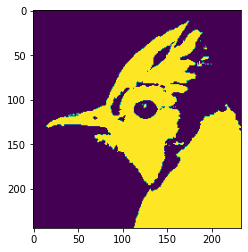

In [7]:
centroids, labels = my_kmeans(gray_img, 2)
print(centroids)
plt.imshow(labels)

[[0.82254001 0.7528362  0.72868667]
 [0.23840714 0.32625181 0.22160547]]


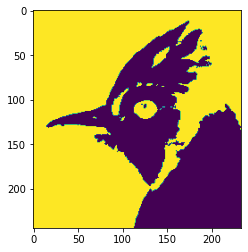

In [8]:
centroids, labels = my_kmeans_rgb(img, 2)
print(centroids)
plt.imshow(labels)

### More things to try out:
1. Try different values for k. For k > 2 you will need some way to display the output L (other than simple black and white). Consider using a colour map with the imshow function.
2. Adapt your function so that it will handle colour images as well. What changes do you have to make?

In [9]:
# k=3
centroids, labels = my_kmeans(gray_img, 3)
plt.imshow(labels)
print(centroids)

[[0.28073346]
 [0.82427177]
 [0.62573183]]


In [10]:
centroids, labels = my_kmeans_rgb(img, 3)
plt.imshow(labels)
print(centroids)

[[0.60381903 0.51146618 0.47752351]
 [0.21663891 0.31806791 0.20742553]
 [0.85227913 0.78887625 0.76721473]]
